# Correlations of xLASM grain sizes and CFA on bag resolution
***
* Author: Yannick E. Heiser
* Email:  wfg813@alumni.ku.dk
* Last Update:   14th of May 2023
***

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from iminuit import Minuit 
from ExternalFunctions import Chi2Regression
plt.rcParams['axes.labelsize'] = 20
plt.rcParams['font.size'] = 20
plt.rcParams['axes.titlesize'] = 20
plt.rcParams['xtick.labelsize'] = 20
plt.rcParams['ytick.labelsize'] = 20
plt.rcParams['legend.fontsize'] = 20
plt.rcParams['axes.axisbelow'] = True
import sys
import glob
import os
from tkinter import Tcl
from os.path import join
from scipy.ndimage import gaussian_filter1d
from scipy.signal import welch, correlate
from scipy.stats import pearsonr, linregress
from scipy.interpolate import CubicSpline, PchipInterpolator
import matplotlib.ticker as ticker
!{sys.executable} -m pip install xlrd

### 1. Load xLASM data

In [2]:
file_path = "/home/jovyan/work/PICE/ResearchGroups/Stratigraphy/Yannick 2022/Data_csv/grain_properties/"
bag_list = ["nmx3642b_1","nmx3642b_2","nmx3642c_1","nmx3642c_2","nmx3643b_1","nmx3643b_2","nmx3644b_1","nmx3644b_2","nmx3645c_1","nmx3646b_1","nmx3646b_2",
            "nmx3647b_1","nmx3647b_2","nmx3649c_1","nmx3649c_2","nmx3650c_1","nmx3650c_2","nmx3651b_1","nmx3651b_2","nmx3652b_1","nmx3652b_2","nmx3653b_1",
            "nmx3653b_2","nmx3655c_1","nmx3655c_2","nmx3656c_1","nmx3656c_2","nmx3657b_1","nmx3657b_2","nmx3658b_1","nmx3658b_2","nmx3659b_1","nmx3659b_2",
            "nmx3661b_1","nmx3662b_1","nmx3662b_2","nmx3663b_1","nmx3663b_2","nmx3664d_1","nmx3664d_2","nmx3665b_1","nmx3667b_1","nmx3667b_2","nmx3668c_1",
            "nmx3668c_2","nmx3669c_1","nmx3669c_2","nmx3670b_1","nmx3670b_2","nmx3671b_1","nmx3671b_2","nmx3673c_1","nmx3673c_2","nmx3674c_1","nmx3674c_2",
            "nmx3676c_1","nmx3676c_2","nmx3677d_1","nmx3677d_2","nmx3680b_1","nmx3680b_2","nmx3681c_1","nmx3681c_2","nmx3682c_1","nmx3682c_2","nmx3684b_1",
            "nmx3684b_2","nmx3685c_1","nmx3685c_2","nmx3686c_1","nmx3686c_2"]
len_img = 12000 #12000 pixel = 6cm
step_size = 200 #200 pixel = 1mm
overlap = 2000 # length of overlap of cropped images 2000px=1cm
px_to_cm = 1/2000 #1px = 1/2000cm
interval_half = 10/10/2/px_to_cm #interval size: change first number to interval size in mm, 1000 pixel = 5mm

def read_csv(path,bags):
    """
    read in csv files with grain size data and put it in dict of dataframes
    --------------------------------------
    param: (str) path: path of csv files
    param: (array) bags: list of bag name strings
    return: (dict) df: dictionary with containing DFs of data
    """
    df = {}
    for i in range(len(bags)):
        bag = str(bags[i])
        print(bag)
        if path != None:
            os.chdir(path + bag)    
        files = glob.glob("*.csv")
        files = Tcl().call('lsort', '-dict', files) #sort csv files after name
        df[bag] = pd.DataFrame()
        for i in range(len(files)):
            file = files[i]
            new_df = pd.read_csv(file)
            new_col = np.ones(new_df.shape[0])*i
            new_col = new_col.astype(int)
            new_df["crop_image"] = new_col
            df[bag] = pd.concat([df[bag],new_df],ignore_index=True)
    os.chdir("/home/jovyan/work/Master Thesis")
    return df

In [3]:
df = read_csv(file_path,bag_list)
print("Shape of dataframes: ",df["nmx3668c_1"].shape)

nmx3642b_1
nmx3642b_2
nmx3642c_1
nmx3642c_2
nmx3643b_1
nmx3643b_2
nmx3644b_1
nmx3644b_2
nmx3645c_1
nmx3646b_1
nmx3646b_2
nmx3647b_1
nmx3647b_2
nmx3649c_1
nmx3649c_2
nmx3650c_1
nmx3650c_2
nmx3651b_1
nmx3651b_2
nmx3652b_1
nmx3652b_2
nmx3653b_1
nmx3653b_2
nmx3655c_1
nmx3655c_2
nmx3656c_1
nmx3656c_2
nmx3657b_1
nmx3657b_2
nmx3658b_1
nmx3658b_2
nmx3659b_1
nmx3659b_2
nmx3661b_1
nmx3662b_1
nmx3662b_2
nmx3663b_1
nmx3663b_2
nmx3664d_1
nmx3664d_2
nmx3665b_1
nmx3667b_1
nmx3667b_2
nmx3668c_1
nmx3668c_2
nmx3669c_1
nmx3669c_2
nmx3670b_1
nmx3670b_2
nmx3671b_1
nmx3671b_2
nmx3673c_1
nmx3673c_2
nmx3674c_1
nmx3674c_2
nmx3676c_1
nmx3676c_2
nmx3677d_1
nmx3677d_2
nmx3680b_1
nmx3680b_2
nmx3681c_1
nmx3681c_2
nmx3682c_1
nmx3682c_2
nmx3684b_1
nmx3684b_2
nmx3685c_1
nmx3685c_2
nmx3686c_1
nmx3686c_2
Shape of dataframes:  (178059, 10)


In [4]:
df["nmx3686c_2"].tail()

,Unnamed: 0,area,equivalent_diameter,centroid_x,centroid_y,orientation,major_axis_length,minor_axis_length,perimeter,crop_image
29983,3019,25,1.128379,1052.0,2794.0,45.000016,0.0,0.0,0.0,10
29984,3020,25,1.128379,1053.0,2795.0,45.000016,0.0,0.0,0.0,10
29985,3021,25,1.128379,984.0,2796.0,45.000016,0.0,0.0,0.0,10
29986,3022,25,1.128379,1054.0,2796.0,45.000016,0.0,0.0,0.0,10
29987,3023,25,1.128379,1055.0,2797.0,45.000016,0.0,0.0,0.0,10


In [5]:
# Define lower cut-off threshold
cut_off = 100000
for bag in df.keys():
    df[bag] = df[bag][df[bag].area > cut_off]

In [6]:
def mean_size(df,list_bags):
    """
    create list of mean grain sizes for each bag
    ----------------------------------------------
    param: (dict) df: dictonary of dataframes with grain parameters
    param: (arraylike) list_bags: list of complete bags
    return: (dataframe) mean_sizes: df of mean grain size for each bag
    """
    mean_sizes = pd.DataFrame(columns=["bag","grain_size[px]"])
    
    # bag 3642
    mean = np.mean(np.concatenate((df["nmx3642b_1"]["area"],df["nmx3642b_2"]["area"],df["nmx3642c_1"]["area"],df["nmx3642c_2"]["area"])))
    new_df = pd.DataFrame([["nmx3642b",mean]],columns=["bag","grain_size[px]"])
    mean_sizes = pd.concat([mean_sizes,new_df],ignore_index=True)

    for bag in list_bags[2:]: #loop over bags
        print(bag)
        bag_1 = bag + "_1"
        bag_2 = bag + "_2" 
        try:
            mean = np.mean(np.concatenate((df[bag_1]["area"],df[bag_2]["area"])))
        except:
            print("Warning: no bag_2 file")
            mean = np.mean(df[bag_1]["area"])
        new_df = pd.DataFrame([[bag,mean]],columns=["bag","grain_size[px]"])
        mean_sizes = pd.concat([mean_sizes,new_df],ignore_index=True)
    return mean_sizes

In [7]:
bag_list1 = ["nmx3642b","nmx3642c","nmx3643b","nmx3644b","nmx3645c","nmx3646b","nmx3647b","nmx3649c","nmx3650c","nmx3651b","nmx3652b",
             "nmx3653b","nmx3655c","nmx3656c","nmx3657b","nmx3658b","nmx3659b","nmx3661b","nmx3662b","nmx3663b","nmx3664d","nmx3665b",
             "nmx3667b","nmx3668c","nmx3669c","nmx3670b","nmx3671b","nmx3673c","nmx3674c","nmx3676c","nmx3677d","nmx3680b","nmx3681c",
             "nmx3682c","nmx3684b","nmx3685c","nmx3686c"]

df_mean = mean_size(df,bag_list1)

nmx3643b
nmx3644b
nmx3645c
nmx3646b
nmx3647b
nmx3649c
nmx3650c
nmx3651b
nmx3652b
nmx3653b
nmx3655c
nmx3656c
nmx3657b
nmx3658b
nmx3659b
nmx3661b
nmx3662b
nmx3663b
nmx3664d
nmx3665b
nmx3667b
nmx3668c
nmx3669c
nmx3670b
nmx3671b
nmx3673c
nmx3674c
nmx3676c
nmx3677d
nmx3680b
nmx3681c
nmx3682c
nmx3684b
nmx3685c
nmx3686c


### 2. Load CFA data

In [8]:
NEEM_path = "/home/jovyan/work/PICE/ResearchGroups/Stratigraphy/Yannick 2022/Data_NEEM/NEEM_CFA/" 
CFA_path = NEEM_path + "NEEM_CFA_1mm_2000-2050m.xls"

# Import the CFA data
CFA_data = pd.ExcelFile(CFA_path)
  
# View the sheet names
print(CFA_data.sheet_names)
  
# Load the excel_file's Sheet1 as a dataframe
CFA_df = CFA_data.parse('Sheet1')
CFA_df.head(5)

['Sheet1']


,Depth top (m),Cond (mikroS/cm),Na+ (ng/g),Ca++ (ng/g),Dust (#/mL) [SD>1.0],NH4+ (ng/g),NO3- (ng/g),H2O2 (ng/g),age (yr b2k)
0,2000.000,0.9572,49.3999,125.8613,35399.5219,3.1761,63.1084,NaN,70657.454545
1,2000.001,0.9280,47.9047,121.7237,35003.0868,3.0861,61.4177,NaN,70657.701818
2,2000.002,0.9014,46.4337,117.9628,33476.2933,3.0041,59.8933,NaN,70657.949091
3,2000.003,0.8614,44.1221,112.4952,29955.4606,2.8934,57.7212,NaN,70658.196364
4,2000.004,0.8292,42.0553,108.1816,28090.3967,2.8147,56.0782,NaN,70658.443636


In [9]:
# Create dataset of CFA mean dust and Ca2+ for each xLASM bag
mean_dust = np.array([])
mean_Ca2 = np.array([])
mean_cond = np.array([])
mean_Na = np.array([])
mean_NO3 = np.array([])
mean_NH4 = np.array([])

for bag in list(df_mean.bag):
    bag_number = int(bag[-5:-1])
    depth_min = (bag_number-1)*0.55
    depth_max = bag_number*0.55
    CFA_slic = CFA_df[CFA_df["Depth top (m)"]>=depth_min]
    CFA_slic = CFA_slic[CFA_slic["Depth top (m)"]<=depth_max]
    mean_dust = np.append(mean_dust,np.mean(CFA_slic["Dust (#/mL) [SD>1.0]"]))
    mean_Ca2 = np.append(mean_Ca2,np.mean(CFA_slic["Ca++ (ng/g)"]))
    mean_cond = np.append(mean_cond,np.mean(CFA_slic["Cond (mikroS/cm)"]))
    mean_Na = np.append(mean_Na,np.mean(CFA_slic["Na+ (ng/g)"]))
    mean_NO3 = np.append(mean_NO3,np.mean(CFA_slic["NO3- (ng/g)"]))
    mean_NH4 = np.append(mean_NH4,np.mean(CFA_slic["NH4+ (ng/g)"]))
df_mean["Cond (mikroS/cm)"] = mean_cond
df_mean["Na+ (ng/g)"] = mean_Na
df_mean["Ca++ (ng/g)"] = mean_Ca2
df_mean["Dust (#/mL) [SD>1.0]"] = mean_dust
df_mean["NH4+ (ng/g)"] = mean_NH4
df_mean["NO3- (ng/g)"] = mean_NO3

df_mean.head()

,bag,grain_size[px],Cond (mikroS/cm),Na+ (ng/g),Ca++ (ng/g),Dust (#/mL) [SD>1.0],NH4+ (ng/g),NO3- (ng/g)
0,nmx3642b,2.688157e+06,1.049249,27.219336,54.721661,18327.243005,0.918305,66.385054
1,nmx3643b,2.434799e+06,0.857454,25.910191,55.816569,17411.121258,1.884307,67.562462
2,nmx3644b,2.439809e+06,0.935871,26.697498,61.856040,20035.506567,1.569202,66.246821
3,nmx3645c,2.636474e+06,0.873258,28.745490,61.718452,16730.777507,1.621255,63.296243
4,nmx3646b,2.648044e+06,0.986988,27.346751,41.139006,11480.405694,1.159713,59.582429


### 3. Correlations

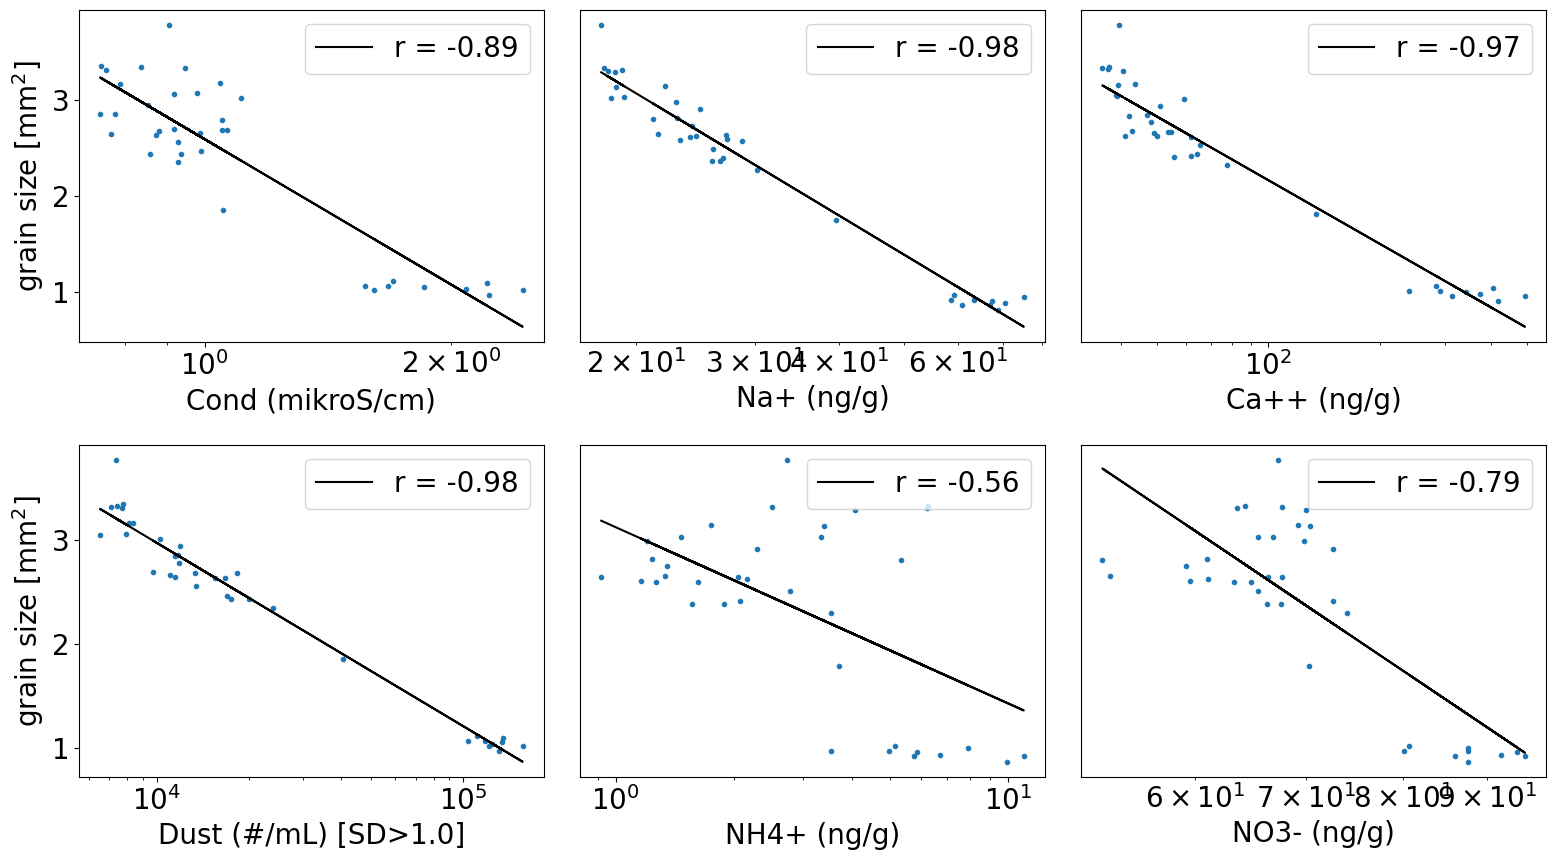

In [11]:
# Make correlations 
fig, ax = plt.subplots(2,3,figsize=(16, 9))
keys_list = list(df_mean.keys())[2:]
for i in range(2):    
    for j in range(3):
        key = keys_list[j+i*3]
        corr = linregress(np.log(df_mean[key]),df_mean["grain_size[px]"]/1000000)
        ax[i,j].semilogx(df_mean[key],df_mean["grain_size[px]"]/1000000,".")
        ax[i,j].semilogx(df_mean[key],corr.intercept+corr.slope*np.log(df_mean[key]),"-",color="black",label="r = {}".format(round(corr.rvalue,2)))
        if j == 0:
            ax[i,j].set_ylabel(r"grain size [mm$^2$]")
        else:
            ax[i,j].set_yticks([])
        ax[i,j].set_xlabel(key)
        #ax[i,j].set_title("Correlation grain size and {}".format(key[:4]))
        ax[i,j].legend(loc="upper right")
fig.tight_layout()
fig.savefig("Plots/22_CFA_xLASM_corr_bags.png",dpi=100)
fig.show()